In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy import sparse

In [2]:
def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    pcm = ax.pcolormesh(xm, ym, data)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

## Introduction

I've made some changes to our files so we can solve equations in multiple spatial dimensions. Now you can make multiple `Grid`s and put them together into a `Domain`. Previously, we would often pass the `Grid` to different objects (`Field`, `Operator`, etc.); now instead we will pass the `Domain`.

In [3]:
grid_x = field.UniformPeriodicGrid(100, 2*np.pi)
grid_y = field.UniformPeriodicGrid(100, 2*np.pi)
domain = field.Domain((grid_x, grid_y))

In [10]:
x, y = domain.values()
xm, ym = domain.plotting_arrays()

In [11]:
u = field.Field(domain)

In [13]:
u.data.shape

(100, 100)

In [14]:
u.data[:] = x+y

When you make derivative operators, you now need to specify the direction the derivative is being taken in.

In [18]:
dudx = spatial.FiniteDifferenceUniformGrid(1, 2, u, 0)
dudy = spatial.FiniteDifferenceUniformGrid(1, 2, u, 1)

In [19]:
u.data[:] = np.sin(x) + np.cos(y)

In [23]:
v = dudy.evaluate()

In [26]:
np.max(np.abs(v.data + np.sin(y)))

0.000657843760160759

<IPython.core.display.Javascript object>


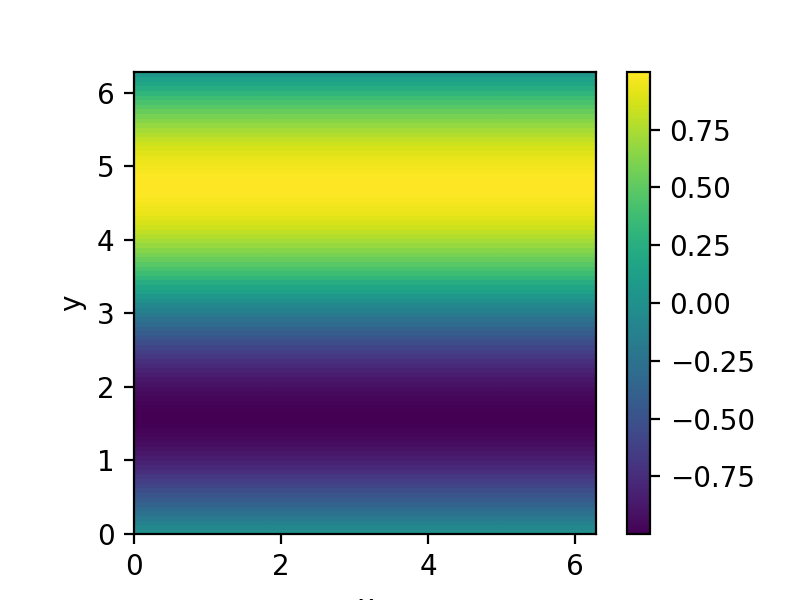

In [24]:
plot_2D_field(xm, ym, v.data)

## Advection Problem

Now we're going to do a simple advection problem. We will solve
$$\partial_t c + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} c = 0$$
Here $\boldsymbol{u}=(u, v)$ is a constant advection velocity. We will solve this problem using an explicit method.

In [27]:
class Advection:
    
    def __init__(self, X, u, v, dcdx, dcdy):
        self.X = X
        c = X.field_list[0]
        self.domain = c.domain
        
        self.F_ops = [-u*dcdx - v*dcdy]

In [46]:
N = 100
grid_x = field.UniformPeriodicGrid(N, 2*np.pi)
grid_y = field.UniformPeriodicGrid(N, 2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()
xm, ym = domain.plotting_arrays()

u = field.Field(domain)
v = field.Field(domain)
c = field.Field(domain)
X = field.FieldSystem([c])

dcdx = spatial.FiniteDifferenceUniformGrid(1, 4, c, 0)
dcdy = spatial.FiniteDifferenceUniformGrid(1, 4, c, 1)

advect = Advection(X, u, v, dcdx, dcdy)

IC = np.exp( - ( (x-np.pi)**2 + (y-np.pi)**2)*8 )
c.data[:] = IC
u.data[:] = -1
v.data[:] = 1

To timestep the problem, we use a new `ExplicitTimestepper`.

In [47]:
ts = timesteppers.PredictorCorrector(advect)
alpha = 0.1
dt = grid_x.dx*alpha

<IPython.core.display.Javascript object>


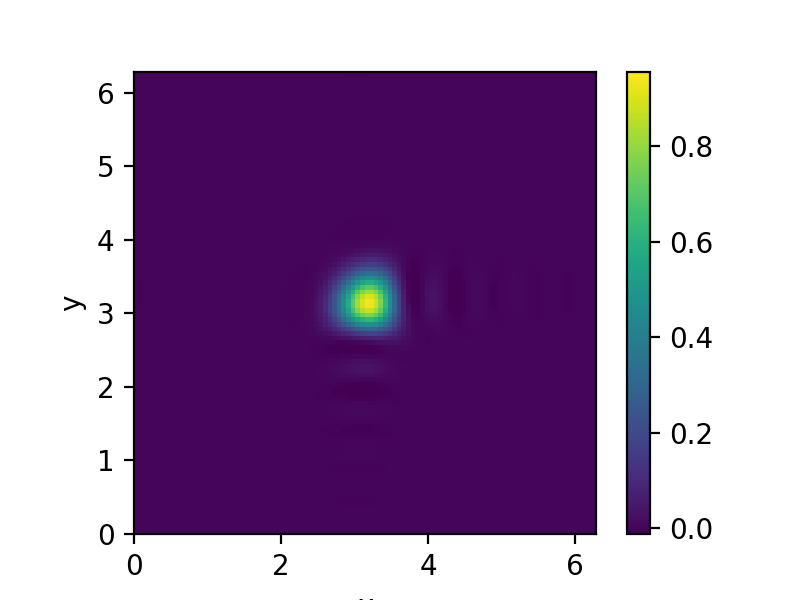

In [52]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(xm, ym, c.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()
while ts.t < 12*np.pi:
    ts.step(dt)
    if ts.iter % 50 == 0:
        pcm.set_array(np.ravel(c.data))
        fig.canvas.draw()

## Implicit Timestepping

Implicit timestepping is a bit more complicated in 2D. We need to think about the matrix form of our operators.

In [3]:
N = 10
grid_x = field.UniformPeriodicGrid(N, 2*np.pi)
grid_y = field.UniformPeriodicGrid(N, 2*np.pi)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

u = field.Field(domain)

In [4]:
dudx = spatial.FiniteDifferenceUniformGrid(1, 2, u, 0)
dudy = spatial.FiniteDifferenceUniformGrid(1, 2, u, 1)

/opt/miniconda3/envs/dedalus/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [70]:
u.data.shape

(10, 10)

In [10]:
#op = u + dudx

In [16]:
op = u + dudx + dudy

<IPython.core.display.Javascript object>


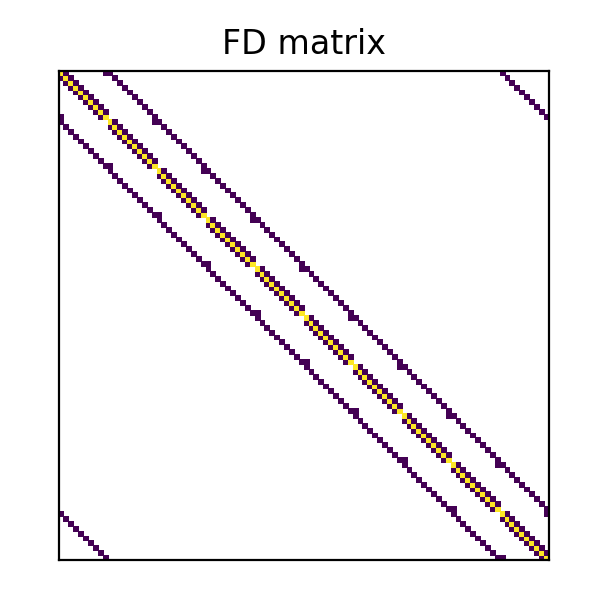

In [17]:
dudx._plot_2D(op._full_matrix.A)

In [18]:
LU = sparse.linalg.splu(op._full_matrix.tocsc(), permc_spec='NATURAL')

In [20]:
LU.U

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1816 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


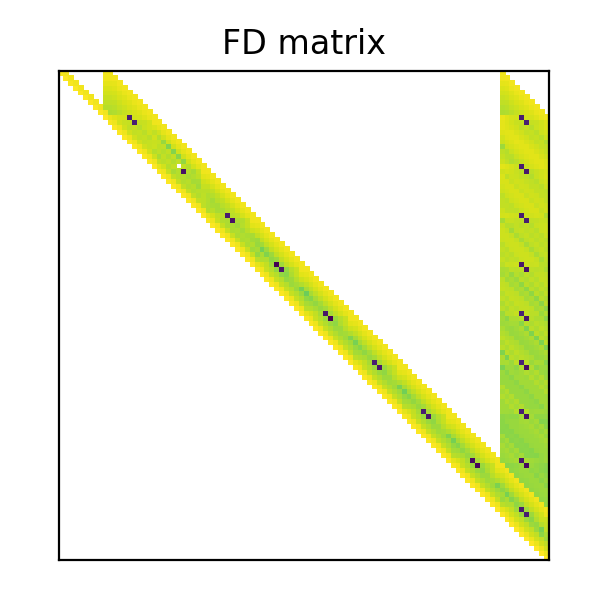

In [19]:
dudx._plot_2D(LU.U.A)

In [62]:
dudx._full_matrix

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in COOrdinate format>

<IPython.core.display.Javascript object>


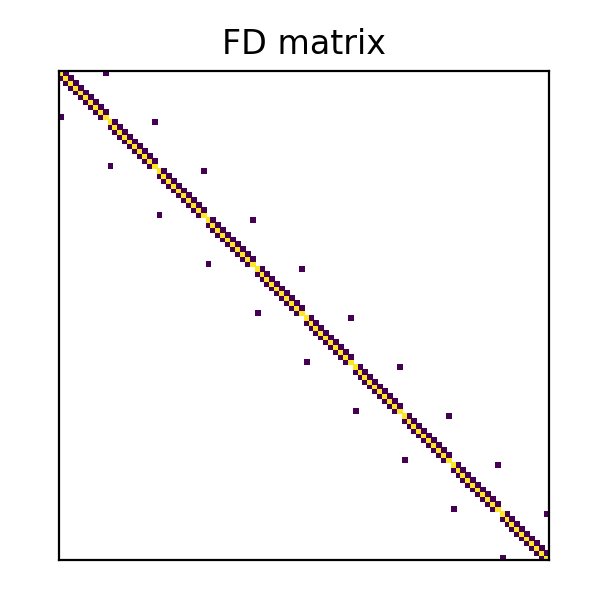

In [76]:
dudx._plot_2D(op._full_matrix.A)

In [69]:
dudy._full_matrix

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in COOrdinate format>

<IPython.core.display.Javascript object>


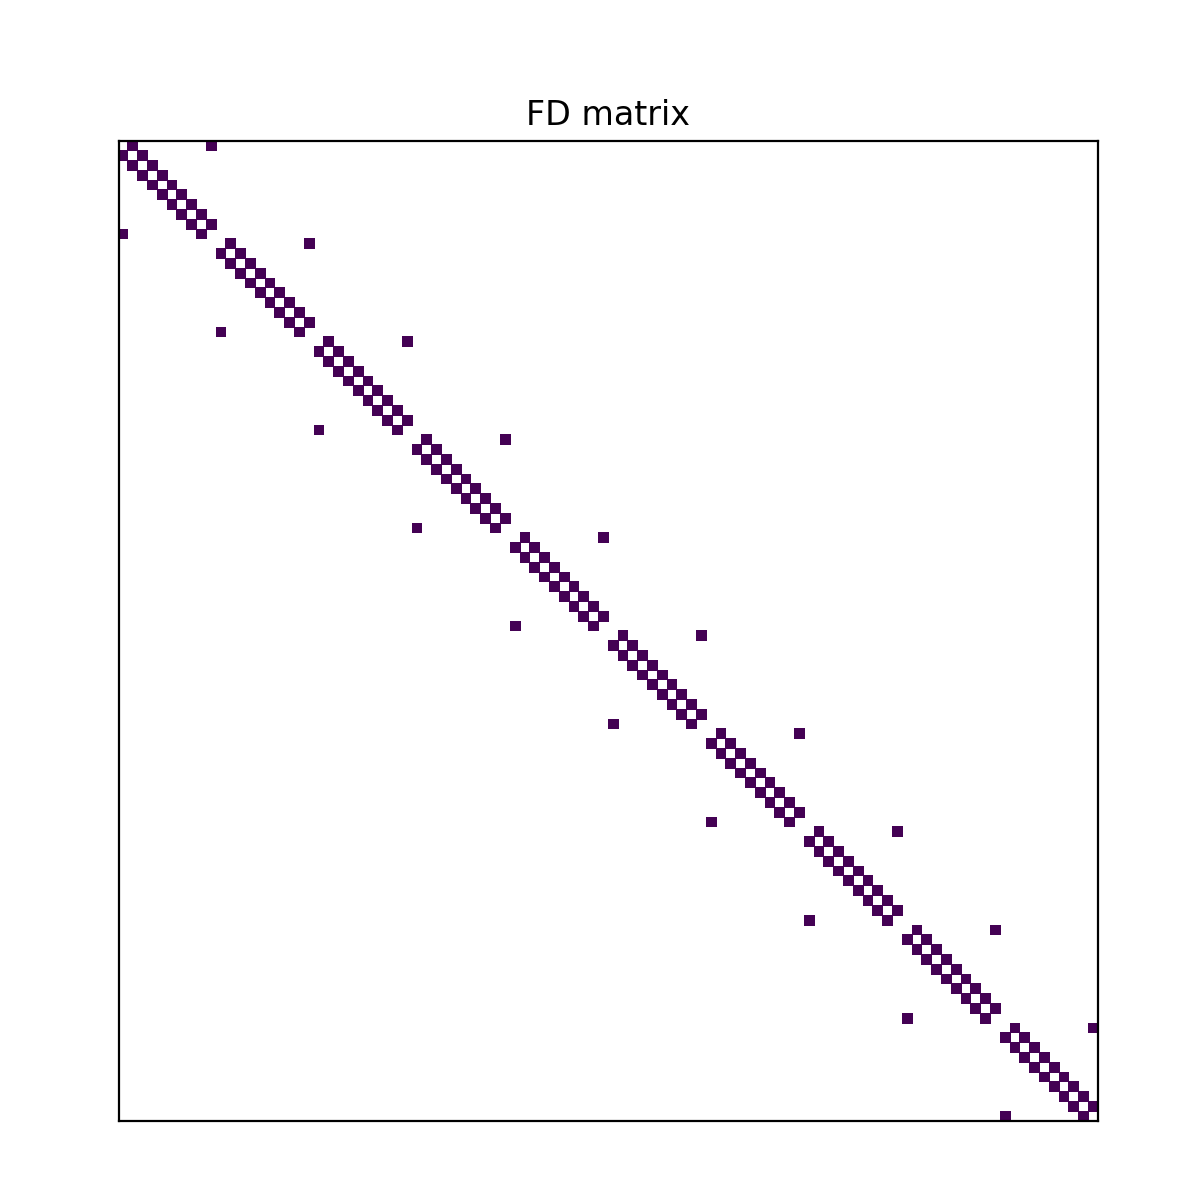

In [68]:
dudx._plot_2D(dudy._full_matrix.A)

## Diffusion Problem

As an example of a problem we can solve with implicit timestepping, we will solve the 2D diffusion problem
$$\partial_t c - D \nabla^2 c = \partial_t c - D (\partial_x^2 + \partial_y^2) c = 0.$$
This equation has the azimuthally symmetric solution
$$c(r,t) = \frac{1}{t}\exp(-r^2/(4t)).$$
We will use operator splitting and solve these two equations separately:
$$\partial_t c - D \partial_x^2 c = 0$$
$$\partial_t c - D \partial_y^2 c = 0$$

In [21]:
class Diffusionx:
    
    def __init__(self, X, D, dcdx2):
        c = X.field_list[0]
        self.X = X
        self.domain = c.domain
        
        ct = field.Field(self.domain)
        
        eq1 = ct - D*dcdx2
        
        self.M = eq1.field_coeff(ct, axis=0)
        self.L = eq1.field_coeff(c, axis=0)
        
class Diffusiony:
    
    def __init__(self, X, D, dcdy2):
        c = X.field_list[0]
        self.X = X
        self.domain = c.domain
        
        ct = field.Field(self.domain)
        
        eq1 = ct - D*dcdy2
        
        self.M = eq1.field_coeff(ct, axis=1)
        self.L = eq1.field_coeff(c, axis=1)

In [22]:
N = 200
grid_x = field.UniformPeriodicGrid(N, 20)
grid_y = field.UniformPeriodicGrid(N, 20)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()
xm, ym = domain.plotting_arrays()

r = np.sqrt((x-10)**2 + (y-10)**2)

IC = np.exp(-r**2/4)
# t = 2, so evolve forward for 1 unit
target = 1/2*np.exp(-r**2/8)

To timestep this problem, we will use an `ImplicitTimestepper`.

In [37]:
c = field.Field(domain)
X = field.FieldSystem([c])
dcdx2 = spatial.FiniteDifferenceUniformGrid(2, 4, c, 0)
dcdy2 = spatial.FiniteDifferenceUniformGrid(2, 4, c, 1)
D = 1
diffx = Diffusionx(X, D, dcdx2)
diffy = Diffusiony(X, D, dcdy2)
ts_x = timesteppers.CrankNicolson(diffx, 0)
ts_y = timesteppers.CrankNicolson(diffy, 1)
c.data[:] = IC
alpha = 0.125
dt = alpha*grid_x.dx

In [38]:
def step_xy(dt):
    ts_y.step(dt)
    ts_x.step(dt)

<IPython.core.display.Javascript object>


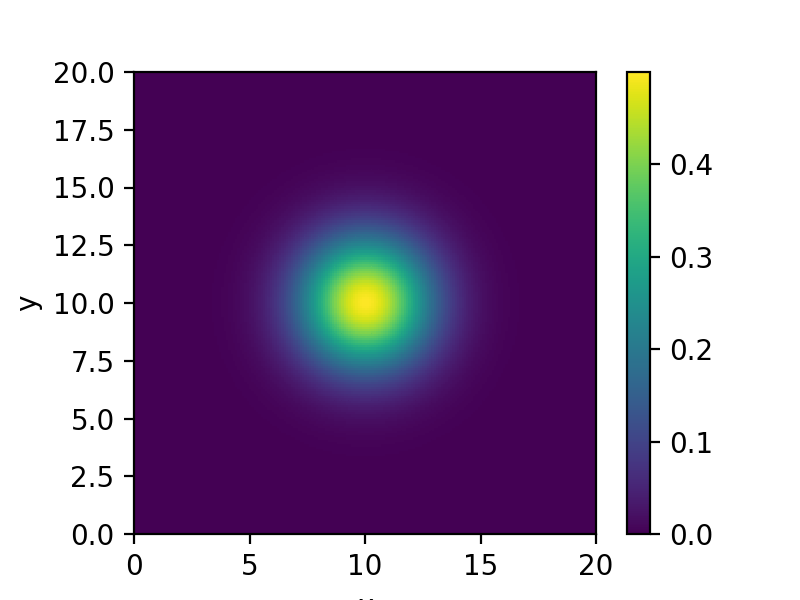

-1.5543122344752192e-15


In [39]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(xm, ym, c.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.canvas.draw()
while ts_x.t < 1 - 1e-5:
    step_xy(dt)
    if ts_x.iter % 1 == 0:
        pcm.set_array(np.ravel(c.data))
        pcm.set_clim([0,np.max(c.data)])
        fig.canvas.draw()
print(ts_x.t - 1)

In [36]:
# alpha = 0.25
np.max(np.abs(c.data - target))

1.1947998419636896e-05

In [40]:
# alpha = 0.125
np.max(np.abs(c.data - target))

2.7918052978304075e-06

In [41]:
1.1947998419636896e-05/2.7918052978304075e-06

4.279667507229831

### My stuff

In [90]:
class Diffusion_split:
    
    def __init__(self, X, D, dc2, axis):
        c = X.field_list[0]
        self.X = X
        self.domain = c.domain
        
        ct = field.Field(self.domain)
        
        eq1 = ct - D*dc2
        
        self.M = eq1.field_coeff(ct, axis=axis)
        self.L = eq1.field_coeff(c, axis=axis)
        self.F_ops = [0*c]
        
class Reaction:
    def __init__(self, X):
        c = X.field_list[0]
        self.X = X
        self.domain = c.domain
        
        ct = field.Field(self.domain)
        
        eq1 = ct
        
        self.M = eq1.field_coeff(ct)
        self.L = eq1.field_coeff(c)
        self.F_ops = [c*(1-c)]


class ReactionDiffusion2D:

    def __init__(self, X, D, dcdx2, dcdy2):
        ## init
        self.t    = 0.
        self.iter = 0
        
        c = X.field_list[0]
        self.X = X
        self.domain = c.domain
        
        ct = field.Field(self.domain)
        
        self.operators = [Diffusion_splot(self.X, D, dcdx2, 0), Diffusion_split(self.X, D, dcdy2, 1), Reaction(self.X)]
        self.ts_list   = [timesteppers.CrankNicolson(self.operators[0], 0),
                          timesteppers.CrankNicolson(self.operators[1], 1),
                          timesteppers.PredictorCorrector(self.operators[2])]        

    def step(self, dt):
        
        # diffusive terms commute, only have to strang split the other terms
        self.ts_list[2].step(dt/2.)
        self.ts_list[1].step(dt)
        self.ts_list[0].step(dt)
        self.ts_list[2].step(dt/2.)
            
        
        # update self.t and self.iter
        self.t += dt
        self.iter += 1

False


<IPython.core.display.Javascript object>


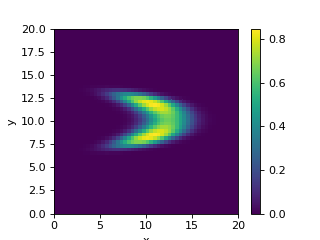

0.0018765057016902897 0.003


In [91]:
error_RD   = {(50,0.5):3e-3, (50,0.25):2.5e-3, (50,0.125):2.5e-3,(100,0.5):4e-4, (100,0.25):2e-4, (100,0.125):1e-4, (200,0.5):8e-5, (200,0.25):2e-5, (200,0.125):5e-6}
resolutions = [50, 100, 200]
alphas      = [0.5, 0.25, 0.125]

###
alpha = alphas[0]
resolution = resolutions[0]


###

grid_x = field.UniformPeriodicGrid(resolution, 20)
grid_y = field.UniformPeriodicGrid(resolution, 20)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

IC = np.exp(-(x+(y-10)**2-14)**2/8)*np.exp(-((x-10)**2+(y-10)**2)/10)

c = field.Field(domain)
X = field.FieldSystem([c])
c.data[:] = IC
D = 1e-2

dcdx2 = spatial.FiniteDifferenceUniformGrid(2, 8, c, 0)
dcdy2 = spatial.FiniteDifferenceUniformGrid(2, 8, c, 1)

rd_problem = ReactionDiffusion2D(X, D, dcdx2, dcdy2)

dt = alpha*grid_x.dx

tmax = 1-1e-5
while rd_problem.t < tmax:
    #print(c.data[:].max())
    rd_problem.step(dt)

print((c.data[:]==IC).all())
xm, ym = domain.plotting_arrays()
plot_2D_field(xm, ym, c.data)

if 1:
    solution = np.loadtxt('c_%i.dat' %resolution)
    error = np.max(np.abs(solution - c.data))

    error_est = error_RD[(resolution,alpha)]

    print(error, error_est)

<IPython.core.display.Javascript object>


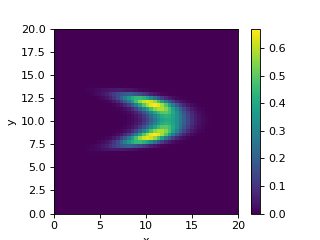

In [115]:
class VB_diffusion_split:
    
    def __init__(self, X, nu, du2, dv2, axis):
        u = X.field_list[0]
        v = X.field_list[1]
        self.X = X        
        self.domain = u.domain
        
        ut = field.Field(self.domain)
        vt = field.Field(self.domain)
        
        eq1_LHS = ut - nu*du2
        eq2_LHS = vt - nu*dv2
        
        M00 = eq1_LHS.field_coeff(ut, axis=axis)
        M01 = eq1_LHS.field_coeff(vt, axis=axis)
        M10 = eq2_LHS.field_coeff(ut, axis=axis)
        M11 = eq2_LHS.field_coeff(vt, axis=axis)
        self.M = sparse.bmat([[M00, M01],
                              [M10, M11]])

        L00 = eq1_LHS.field_coeff(u, axis=axis)
        L01 = eq1_LHS.field_coeff(v, axis=axis)
        L10 = eq2_LHS.field_coeff(u, axis=axis)
        L11 = eq2_LHS.field_coeff(v, axis=axis)
        self.L = sparse.bmat([[L00, L01],
                              [L10, L11]])        
        
        self.F_ops = [0*u, 0*v]
        
class VB_advection_split:
    
    def __init__(self, X, dudx, dudy, dvdx, dvdy):
        u = X.field_list[0]
        v = X.field_list[1]
        self.X = X        
        self.domain = u.domain

        ut = field.Field(self.domain)
        vt = field.Field(self.domain)
        
        eq1_LHS = ut
        eq2_LHS = vt
        
        M00 = eq1_LHS.field_coeff(ut)
        M01 = eq1_LHS.field_coeff(vt)
        M10 = eq2_LHS.field_coeff(ut)
        M11 = eq2_LHS.field_coeff(vt)
        self.M = sparse.bmat([[M00, M01],
                              [M10, M11]])

        L00 = eq1_LHS.field_coeff(u)
        L01 = eq1_LHS.field_coeff(v)
        L10 = eq2_LHS.field_coeff(u)
        L11 = eq2_LHS.field_coeff(v)
        self.L = sparse.bmat([[L00, L01],
                              [L10, L11]])

        self.F_ops = [-u*dudx - v*dudy, -u*dvdx - v*dvdy]

class ViscousBurgers2D:

    def __init__(self, X, nu, spatial_order):
        ## init
        self.t    = 0.
        self.iter = 0
        
        ## init domain
        u = X.field_list[0]
        v = X.field_list[1]
        self.X = X
        self.domain = u.domain

        ## init derivative operators
        dudx  = spatial.FiniteDifferenceUniformGrid(1, spatial_order, u, 0)
        dudy  = spatial.FiniteDifferenceUniformGrid(1, spatial_order, u, 1)
        dvdx  = spatial.FiniteDifferenceUniformGrid(1, spatial_order, v, 0)
        dvdy  = spatial.FiniteDifferenceUniformGrid(1, spatial_order, v, 1)
        dudx2 = spatial.FiniteDifferenceUniformGrid(2, spatial_order, u, 0)
        dudy2 = spatial.FiniteDifferenceUniformGrid(2, spatial_order, u, 1)
        dvdx2 = spatial.FiniteDifferenceUniformGrid(2, spatial_order, v, 0)
        dvdy2 = spatial.FiniteDifferenceUniformGrid(2, spatial_order, v, 1)
        
        
        
        self.operators = [VB_diffusion_split(self.X, nu, dudx2, dvdx2,0),
                          VB_diffusion_split(self.X, nu, dudy2, dvdy2,1),
                          VB_advection_split(self.X, dudx, dudy, dvdx, dvdy)]
            
            
        self.ts_list   = [timesteppers.CrankNicolson(self.operators[0], 0),
                          timesteppers.CrankNicolson(self.operators[1], 1),
                          timesteppers.PredictorCorrector(self.operators[2])]        

    def step(self, dt):
        # take a step
        # update self.t and self.iter
        
        # diffusive terms commute, only have to strang split the other terms
        self.ts_list[2].step(dt/2.)
        self.ts_list[1].step(dt)
        self.ts_list[0].step(dt)
        self.ts_list[2].step(dt/2.)
            
        
        # update self.t and self.iter
        self.t += dt
        self.iter += 1

/home/nkaaz/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


u.max =  0.021053511712039313
v.max =  1.1490824219990687


<IPython.core.display.Javascript object>


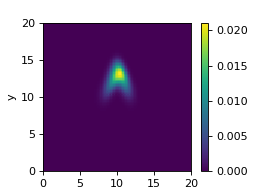

In [3]:
resolutions = [50, 100, 200]
alphas      = [0.5, 0.25, 0.125]

from equations import ViscousBurgers2D

###
alpha = alphas[1]
resolution = resolutions[1]


###

grid_x = field.UniformPeriodicGrid(resolution, 20)
grid_y = field.UniformPeriodicGrid(resolution, 20)
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()

#print(x)
#u_IC = (0.2*np.exp(-(x-10)**2.) + np.ones(np.shape(x)))*np.ones(np.shape(y))
#v_IC = (0.2*np.exp(-(y-10)**2.) + np.ones(np.shape(y)))*np.ones(np.shape(x))
u_IC = (0.2*np.exp(-(x-10)**2.)*0.2*np.exp(-(y-10)**2.))
v_IC = (0.2*np.exp(-(x-10)**2.) + np.ones(np.shape(y)))*np.ones(np.shape(x))

#v_IC = np.zeros((resolution,resolution))

u = field.Field(domain)
v = field.Field(domain)
X = field.FieldSystem([u,v])
u.data[:] = u_IC
v.data[:] = v_IC
nu = 1e-2

vb_problem = ViscousBurgers2D(X, nu, 4)

dt = alpha*grid_x.dx

tmax = 20
while vb_problem.t < tmax:    
    vb_problem.step(dt)
print('u.max = ', u.data[:].max())
print('v.max = ', v.data[:].max())

xm, ym = domain.plotting_arrays()
plot_2D_field(xm, ym, u.data)